In [1]:
import pandas as pd
import json
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
pd.read_csv("song_info_id_index.csv").shape

(8066, 24)

In [769]:
library_df = pd.read_csv("song_library.csv").set_index(["Title", "Artist"])
with open("artist_song_info.csv", "r") as f:
    artist_song_info = json.load(f)
    
info_df = pd.DataFrame(artist_song_info).transpose()

In [57]:
with open("related_artists.json", "r") as f:
    related_artists = json.load(f)

In [58]:
for artist in related_artists:
    rels = []
    for tup in related_artists[artist]:
        rels.append((tup[0], tup[1]))
    info_df.at[artist, 'related'] = rels

In [111]:
print(len(library_df), "songs")
print(len(artist_song_info), "artists")

temp = [re.sub("featuring", ",", artist) for artist in list(library_df.index.get_level_values("Artist"))]
temp = [re.sub("feat.", ",", artist) for artist in list(library_df.index.get_level_values("Artist"))]
features = [artist for artist in temp if len(artist.split(",")) > 1]
print(len(features), "songs with featured artists")

10477 songs
5802 artists
1814 songs with featured artists


In [60]:
Counter(info_df['genres'].dropna().values.sum()).most_common(20)

[('pop', 811),
 ('rap', 699),
 ('pop rap', 568),
 ('dance pop', 538),
 ('trap', 489),
 ('hip hop', 429),
 ('rock', 352),
 ('post-teen pop', 328),
 ('latin', 287),
 ('trap latino', 281),
 ('southern hip hop', 264),
 ('reggaeton', 256),
 ('classic rock', 253),
 ('mellow gold', 246),
 ('soft rock', 233),
 ('album rock', 231),
 ('edm', 218),
 ('pop dance', 213),
 ('melodic rap', 210),
 ('r&b', 200)]

In [61]:
num_feats = Counter([len(artist.split(",")) for artist in list(library_df.index.get_level_values("Artist"))])
num_feats

Counter({1: 9082,
         3: 260,
         2: 978,
         7: 36,
         6: 17,
         4: 60,
         5: 33,
         9: 4,
         8: 3,
         14: 1,
         32: 1,
         18: 1,
         10: 1})

In [62]:
library_df.describe()

,bil_200_first_rank,bil_200_best_rank,tok_first_rank,tok_best_rank,spot_top200_first_rank,spot_top200_best_rank,bil_h100_first_rank,bil_h100_best_rank,usa_v50_first_rank,usa_v50_best_rank,usa_top200_first_rank,usa_top200_best_rank,spot_v50_first_rank,spot_v50_best_rank
count,1975.000000,1975.000000,1889.000000,1889.000000,2516.000000,2516.000000,1757.000000,1757.000000,2394.000000,2394.000000,2990.000000,2990.000000,2241.000000,2241.000000
mean,82.331139,72.954937,47.917417,42.125993,107.068760,88.074722,63.030165,52.015936,26.253968,24.060568,97.159866,83.127425,26.095939,23.726461
std,64.823529,60.272704,28.276771,28.211444,60.448223,58.755760,28.324686,28.528605,14.676389,14.671386,62.219605,59.436110,14.948011,14.764601
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,20.000000,17.500000,23.000000,17.000000,53.000000,36.000000,42.000000,29.000000,14.000000,11.000000,41.000000,29.000000,13.000000,10.000000
50%,71.000000,60.000000,47.000000,38.000000,111.000000,80.500000,68.000000,54.000000,27.000000,23.000000,95.000000,74.000000,27.000000,23.000000
75%,141.000000,121.000000,72.000000,65.000000,163.000000,139.000000,88.000000,76.000000,39.000000,36.750000,154.000000,132.000000,40.000000,37.000000
max,200.000000,200.000000,100.000000,100.000000,200.000000,200.000000,100.000000,100.000000,50.000000,50.000000,200.000000,200.000000,50.000000,50.000000


In [417]:
def compare_tok_to_chart(chart):
    pre_library = library_df[library_df["tok_first_date"] < library_df[f"{chart}_first_date"]][
        ['tok_first_date', "tok_first_rank", 
         f'{chart}_first_date', f"{chart}_first_rank", 
         "tok_best_date", "tok_best_rank",
         f'{chart}_best_date', f"{chart}_best_rank"]]
    
    return pre_library

def analyze_chart(library):

    # drop empty artists from library
    library= library.drop(library.iloc[library.index.get_level_values("Artist") == "-"].index)
    pre_info = info_df.loc[library.index.get_level_values("Artist")]

    
    # extract songs into their own DataFrame
    keys = []
    values = []
    artist_ids = []
    for i, songs in enumerate(pre_info['songs'].values):
        for song in songs.keys():
            if song in library.index.get_level_values("Title"):
                keys.append((song, pre_info.iloc[i].name))
                values.append(songs[song])
                artist_ids.append(pre_info.iloc[i]['artist_id'])
           
    pre_info = pre_info.drop_duplicates("artist_id")
    pre_info = pre_info.set_index("artist_id")
    
    
    song_df = pd.DataFrame(values)
    song_df['artist_id'] = artist_ids

    song_df['artist_popularity'] = pre_info.loc[artist_ids]['artist_popularity'].values.astype(float)
    song_df['followers'] = pre_info.loc[artist_ids]['followers'].values.astype(float)
    song_df['genres'] = pre_info.loc[artist_ids]['genres'].values
    song_df['related'] = pre_info.loc[artist_ids]['related'].values
    
    song_df.index = pd.MultiIndex.from_tuples(keys, names=["Title", "Artist"])
#     song_df.index = song_df.index.rename("Title")
    song_df['audio_feats'] = song_df['audio_feats'].apply(lambda x: {} if pd.isnull(x) else x)
    song_df = song_df.drop_duplicates("song_id")

    
    # extract audio features
    audio_feats = pd.DataFrame.from_records(song_df['audio_feats'].values)
    audio_feats.index = song_df['audio_feats'].index

    # merge audio features with each song
    song_df = song_df.merge(audio_feats, how="outer", left_on="song_id", right_on="id", left_index=True)
    song_df = song_df.drop(columns=["type", "duration", "audio_feats", "id", "uri", "track_href", "analysis_url"])

    return pre_info, song_df

In [487]:
artist_info_df, song_info_df = analyze_chart(library_df)
# song_info.reset_index().set_index("song_id").to_csv("song_info_id_index.csv")

In [311]:
song_info_df.reset_index().set_index("song_id").to_csv("song_info_id_index.csv")

In [208]:
song_attr_df.loc[song_attr_df.index.duplicated()]

,Title,Artist,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,duration_ms,time_signature,artist_id,artist_popularity,followers,genres,related
song_id,,,,,,,,,,,,,,,,,,,,,
3YAnNBdk0uHyakXXzMbNJq,mis manos,camilo,2021-03-04,80.0,0.791,0.649,10.0,-2.312,1.0,0.2760,...,0.9510,190.087,audio_features,221749.0,4.0,28gNT5KBp7IjEOQoevXf9N,90,8739387,"[colombian pop, reggaeton colombiano]","[(Sebastian Yatra, 07YUOmWljBTXwIseAUd9TW), (N..."
3YAnNBdk0uHyakXXzMbNJq,mis manos,camilo,2021-03-04,80.0,0.791,0.649,10.0,-2.312,1.0,0.2760,...,0.9510,190.087,audio_features,221749.0,4.0,28gNT5KBp7IjEOQoevXf9N,90,8739387,"[colombian pop, reggaeton colombiano]","[(Sebastian Yatra, 07YUOmWljBTXwIseAUd9TW), (N..."
3YAnNBdk0uHyakXXzMbNJq,mis manos,camilo,2021-03-04,80.0,0.791,0.649,10.0,-2.312,1.0,0.2760,...,0.9510,190.087,audio_features,221749.0,4.0,28gNT5KBp7IjEOQoevXf9N,90,8739387,"[colombian pop, reggaeton colombiano]","[(Sebastian Yatra, 07YUOmWljBTXwIseAUd9TW), (N..."
3YAnNBdk0uHyakXXzMbNJq,mis manos,camilo,2021-03-04,80.0,0.791,0.649,10.0,-2.312,1.0,0.2760,...,0.9510,190.087,audio_features,221749.0,4.0,28gNT5KBp7IjEOQoevXf9N,90,8739387,"[colombian pop, reggaeton colombiano]","[(Sebastian Yatra, 07YUOmWljBTXwIseAUd9TW), (N..."
3YAnNBdk0uHyakXXzMbNJq,mis manos,camilo,2021-03-04,80.0,0.791,0.649,10.0,-2.312,1.0,0.2760,...,0.9510,190.087,audio_features,221749.0,4.0,28gNT5KBp7IjEOQoevXf9N,90,8739387,"[colombian pop, reggaeton colombiano]","[(Sebastian Yatra, 07YUOmWljBTXwIseAUd9TW), (N..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44wBlg3Y1KSAEmaze5BXe7,i'm in love with an e-girl,wilbur soot,2020-01-24,74.0,0.708,0.434,7.0,-12.522,1.0,0.0681,...,0.3740,80.045,audio_features,239308.0,4.0,2XzXLjXRSeFtsic4ieyLJy,72,870462,[social media pop],"[(Wilbur, 6gKzPziGLKXdUaEEIm86Mn), (Wilbur, 6D..."
2Q1s11otlyEtj80OgsqDFz,internet ruined me,wilbur soot,2020-05-25,73.0,0.726,0.371,9.0,-14.008,1.0,0.0623,...,0.5680,160.240,audio_features,255600.0,4.0,2XzXLjXRSeFtsic4ieyLJy,72,870462,[social media pop],"[(Wilbur, 6gKzPziGLKXdUaEEIm86Mn), (Wilbur, 6D..."
2Q1s11otlyEtj80OgsqDFz,internet ruined me,wilbur soot,2020-05-25,73.0,0.726,0.371,9.0,-14.008,1.0,0.0623,...,0.5680,160.240,audio_features,255600.0,4.0,2XzXLjXRSeFtsic4ieyLJy,72,870462,[social media pop],"[(Wilbur, 6gKzPziGLKXdUaEEIm86Mn), (Wilbur, 6D..."


# Spotify Charts

In [418]:
not_null = [not item for item in library_df['spot_v50_first_rank'].isnull().values]
on_spotv50_info, on_spotv50_songs = analyze_chart(library_df[not_null])

not_null = [not item for item in library_df['spot_top200_first_rank'].isnull().values]
on_spot200_info, on_spot200_songs = analyze_chart(library_df[not_null])

not_null = [not item for item in library_df['usa_v50_first_rank'].isnull().values]
on_usav50_info, on_usav50_songs = analyze_chart(library_df[not_null])

not_null = [not item for item in library_df['usa_top200_first_rank'].isnull().values]
on_usa200_info, on_usa200_songs = analyze_chart(library_df[not_null])

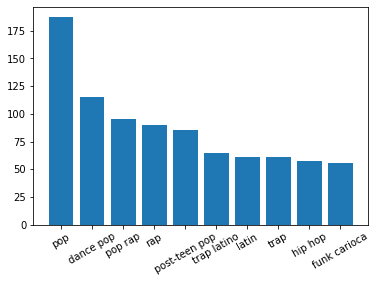

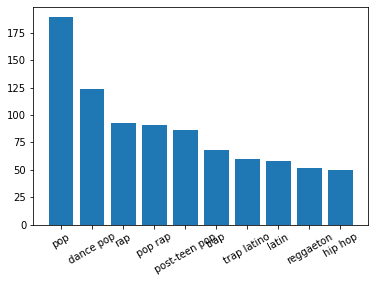

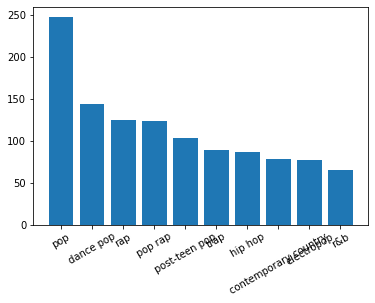

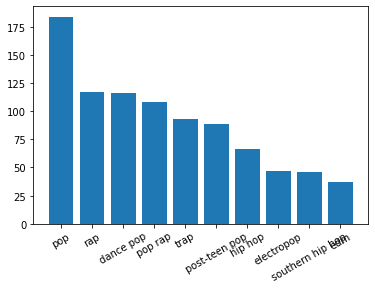

In [419]:
genre_dist = Counter(on_spotv50_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_spotv50_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

genre_dist = Counter(on_spot200_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_spot200_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

genre_dist = Counter(on_usav50_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_spotv50_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

genre_dist = Counter(on_usa200_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_spot200_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

In [420]:
on_spotv50_info.dropna()[['artist_popularity', "followers"]].astype(int).describe()

,artist_popularity,followers
count,1562.000000,1.562000e+03
mean,65.719590,1.976400e+06
std,14.601808,5.568945e+06
min,0.000000,0.000000e+00
25%,57.000000,4.372525e+04
50%,67.000000,2.607950e+05
75%,76.000000,1.258150e+06
max,100.000000,7.958072e+07


In [421]:
song_info.loc[library_df["spot_v50_best_rank"]==1.0].head()

,,song_id,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
Title,Artist,,,,,,,,,,,,,,,,,
моя голова винтом (my head is spinning like a screw),kostromin,4KrhaZm4JRkNO4HRdLvJIG,2021-02-02,78.0,0.833,0.748,1.0,-5.963,1.0,0.2290,0.0331,0.000001,0.0728,0.4840,119.925,audio_features,140000.0,4.0
baby shark,pinkfong,5ygDXis42ncn6kYG14lEVG,2017-07-27,76.0,0.829,0.886,8.0,-1.746,1.0,0.1120,0.2590,0.000000,0.0559,0.7770,115.056,audio_features,80927.0,4.0
halu,feby putri,3c4cBEObUsLU8O5I2yQP3l,2019-08-18,63.0,0.338,0.251,2.0,-14.544,1.0,0.0353,0.8660,0.032400,0.1100,0.0963,116.419,audio_features,265738.0,4.0
"thank u, next",ariana grande,3e9HZxeyfWwjeyPAMmWSSQ,2019-02-08,83.0,0.717,0.653,1.0,-5.634,1.0,0.0658,0.2290,0.000000,0.1010,0.4120,106.966,audio_features,207320.0,4.0
eastside (with halsey & khalid),benny blanco,0d2iYfpKoM0QCKvcLCkBao,2018-07-12,78.0,0.560,0.680,6.0,-7.648,0.0,0.3210,0.5550,0.000000,0.1160,0.3190,89.391,audio_features,173800.0,4.0


In [422]:
song_info.loc[library_df["spot_top200_best_rank"]==1.0].head()

,,song_id,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
Title,Artist,,,,,,,,,,,,,,,,,
7 rings,ariana grande,6ocbgoVGwYJhOv1GgI9NsF,2019-02-08,85.0,0.778,0.317,1.0,-10.732,0.0,0.3340,0.5920,0.00000,0.0881,0.327,140.048,audio_features,178627.0,4.0
"thank u, next",ariana grande,3e9HZxeyfWwjeyPAMmWSSQ,2019-02-08,83.0,0.717,0.653,1.0,-5.634,1.0,0.0658,0.2290,0.00000,0.1010,0.412,106.966,audio_features,207320.0,4.0
positions,ariana grande,35mvY5S1H3J2QZyna3TFe0,2020-10-30,90.0,0.737,0.802,0.0,-4.771,1.0,0.0878,0.4680,0.00000,0.0931,0.682,144.015,audio_features,172325.0,4.0
in my feelings,drake,2G7V7zsVDxg1yRsu7Ew9RJ,2018-06-29,78.0,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.00006,0.3960,0.350,91.030,audio_features,217925.0,4.0
montero (call me by your name),lil nas x,67BtfxlNbhBmCDR2L2l8qd,2021-03-31,98.0,0.610,0.508,8.0,-6.682,0.0,0.1520,0.2970,0.00000,0.3840,0.758,178.818,audio_features,137876.0,4.0


# Billboard Top 200 Chart

In [423]:
not_null = [not item for item in library_df['bil_200_first_rank'].isnull().values]
on_bill200_info, on_bill200_songs = analyze_chart(library_df[not_null])

not_null = [not item for item in library_df['bil_h100_first_rank'].isnull().values]
on_bill100_info, on_bill100_songs = analyze_chart(library_df[not_null])

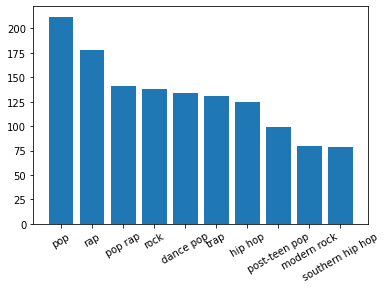

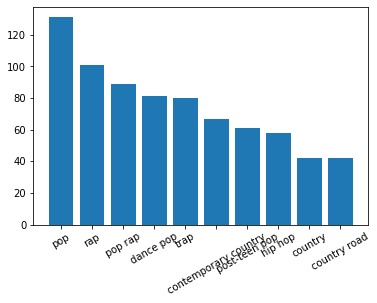

In [424]:
genre_dist = Counter(on_bill200_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_bill200_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

genre_dist = Counter(on_bill100_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_bill100_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);
plt.show();

In [425]:
song_info.loc[library_df["bil_200_best_rank"]==1.0].head()

,,song_id,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
Title,Artist,,,,,,,,,,,,,,,,,
my turn,lil baby,6gxKUmycQX7uyMwJcweFjp,2020-05-01,78.0,0.926,0.542,1.0,-5.064,1.0,0.2930,0.1350,0.0,0.0877,0.564,135.140,audio_features,181929.0,4.0
a love letter to you 4,trippie redd,2ktxr00GpTtbMNeBjNeY8D,2019-11-22,73.0,0.850,0.516,0.0,-7.664,0.0,0.0714,0.7630,0.0,0.0896,0.874,108.963,audio_features,158532.0,4.0
"thank u, next",ariana grande,3e9HZxeyfWwjeyPAMmWSSQ,2019-02-08,83.0,0.717,0.653,1.0,-5.634,1.0,0.0658,0.2290,0.0,0.1010,0.412,106.966,audio_features,207320.0,4.0
positions,ariana grande,35mvY5S1H3J2QZyna3TFe0,2020-10-30,90.0,0.737,0.802,0.0,-4.771,1.0,0.0878,0.4680,0.0,0.0931,0.682,144.015,audio_features,172325.0,4.0
ai youngboy 2,youngboy never broke again,6klLvorLoo1sxvZcjJIY8I,2019-10-11,74.0,0.876,0.733,10.0,-4.478,0.0,0.3330,0.0208,0.0,0.0999,0.962,154.904,audio_features,148630.0,4.0


In [426]:
song_info.loc[library_df["bil_h100_best_rank"]==1.0].head()

,,song_id,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
Title,Artist,,,,,,,,,,,,,,,,,
up,cardi b,1XXimziG1uhM0eDNCZCrUl,2021-02-05,90.0,0.868,0.795,11.0,-6.044,1.0,0.2690,0.0012,0.01930,0.0461,0.819,166.000,audio_features,156945.0,4.0
7 rings,ariana grande,6ocbgoVGwYJhOv1GgI9NsF,2019-02-08,85.0,0.778,0.317,1.0,-10.732,0.0,0.3340,0.5920,0.00000,0.0881,0.327,140.048,audio_features,178627.0,4.0
"thank u, next",ariana grande,3e9HZxeyfWwjeyPAMmWSSQ,2019-02-08,83.0,0.717,0.653,1.0,-5.634,1.0,0.0658,0.2290,0.00000,0.1010,0.412,106.966,audio_features,207320.0,4.0
positions,ariana grande,35mvY5S1H3J2QZyna3TFe0,2020-10-30,90.0,0.737,0.802,0.0,-4.771,1.0,0.0878,0.4680,0.00000,0.0931,0.682,144.015,audio_features,172325.0,4.0
in my feelings,drake,2G7V7zsVDxg1yRsu7Ew9RJ,2018-06-29,78.0,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.00006,0.3960,0.350,91.030,audio_features,217925.0,4.0


# Tik Tok Chart

In [427]:
not_null = [not item for item in library_df['tok_first_rank'].isnull().values]
on_tok_info, on_tok_songs = analyze_chart(library_df[not_null])

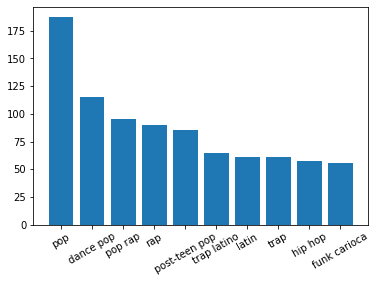

In [428]:
genre_dist = Counter(on_spotv50_info.genres.dropna().values.sum()).most_common(10)
# total = sum(Counter(on_spotv50_info.genres.dropna().values.sum()).values())
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);

In [429]:
on_tok_info.dropna()[['artist_popularity', "followers"]].astype(int).describe().loc["mean"].values

array([5.35478339e+01, 1.98053358e+06])

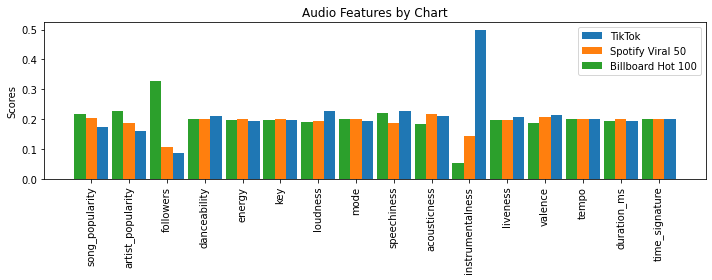

In [430]:
labels = on_tok_songs.describe().loc["mean"].index

tok_stats = on_tok_songs.describe().loc["mean"].values
v50_stats = on_spotv50_songs.describe().loc["mean"].values
s200_stats = on_spot200_songs.describe().loc["mean"].values
bill2_stats = on_bill200_songs.describe().loc["mean"].values
bill1_stats = on_bill100_songs.describe().loc["mean"].values

totals = [tok + v50 + s200 + bill2 + bill1 for tok, v50, s200, bill2, bill1 in zip(tok_stats, v50_stats, s200_stats, bill2_stats, bill1_stats)]
tok_stats /= totals
v50_stats /= totals
s200_stats /= totals
bill2_stats /= totals
bill1_stats /= totals


x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(10,4))
rects1 = ax.bar(x + width, tok_stats, width, label='TikTok')
rects2 = ax.bar(x, v50_stats, width, label='Spotify Viral 50')
# rects2 = ax.bar(x, s200_stats, width, label='Spotify Top 200')
# rects3 = ax.bar(x - width, bill2_stats, width, label='Billboard Top 200')
rects3 = ax.bar(x - width, bill1_stats, width, label='Billboard Hot 100')




# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Audio Features by Chart')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show();

# \#1 on Tik Tok

In [431]:
song_info.loc[library_df["tok_best_rank"]==1.0].head()

,,song_id,release_date,song_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature
Title,Artist,,,,,,,,,,,,,,,,,
falling in love tonight,fantasia,1QYZ5D5pNSRm0Bo7B3Yhv8,2010-08-20,46.0,0.612,0.605,5.0,-6.490,1.0,0.0311,0.011400,0.000110,0.3100,0.201,94.964,audio_features,239027.0,4.0
candy,doja cat,1VJwtWR6z7SpZRwipI12be,2018-03-30,72.0,0.689,0.516,8.0,-5.857,1.0,0.0444,0.513000,0.000000,0.1630,0.209,124.876,audio_features,190920.0,4.0
whole lotta choppas,sada baby,6hLZzCS4E7AWo3PRBWy6az,2020-08-14,65.0,0.926,0.762,1.0,-1.887,1.0,0.2050,0.000718,0.000000,0.1170,0.277,127.931,audio_features,153750.0,4.0
wasabi,little mix,7IOuCLt770D8v0u3SVaDeI,2018-11-16,70.0,0.847,0.656,2.0,-4.976,1.0,0.1150,0.004510,0.000854,0.1430,0.234,114.001,audio_features,154787.0,4.0
love story discolines,ethanishung,2duyHVCqcaX2FSwjzuZijF,2020-09-22,60.0,0.669,0.634,2.0,-4.300,1.0,0.0321,0.068500,0.000000,0.0597,0.276,127.915,audio_features,222957.0,4.0


# TikTok before Spotify Viral 50 (Global)

In [432]:
def tok_first_plot(tok, chart, pre_chart):
    labels = on_tok_songs.describe().loc["mean"].index

    tok_stats = tok.describe().loc["mean"].values
    chart_stats = chart.describe().loc["mean"].values
    pre_stats = pre_chart.describe().loc["mean"].values

    totals = [tok + chart + pre for tok, chart, pre in zip(tok_stats, chart_stats, pre_stats)]
    tok_stats /= totals
    chart_stats /= totals
    pre_stats /= totals


    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,4))
    rects1 = ax.bar(x + width, tok_stats, width, label='TikTok')
    rects2 = ax.bar(x, chart_stats, width, label='Spotify Viral 50')
    rects3 = ax.bar(x - width, pre_stats, width, label='Tok First')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Audio Features by Chart')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=90)

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    return plt.show();

In [433]:
pre_spotv50 = compare_tok_to_chart("spot_v50")
pre_spotv50_info, pre_spotv50_songs = analyze_chart(pre_spotv50)

In [434]:
pre_spotv50_info[['artist_popularity', "followers"]].astype(int).describe()

,artist_popularity,followers
count,36.000000,3.600000e+01
mean,68.333333,5.324408e+06
std,17.926835,1.272027e+07
min,35.000000,1.987000e+03
25%,55.750000,4.717850e+04
50%,71.000000,3.951930e+05
75%,82.250000,3.720583e+06
max,96.000000,6.219153e+07


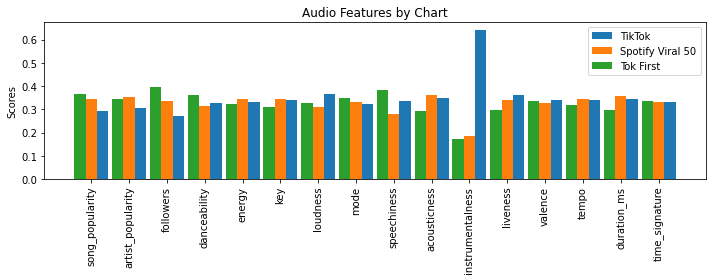

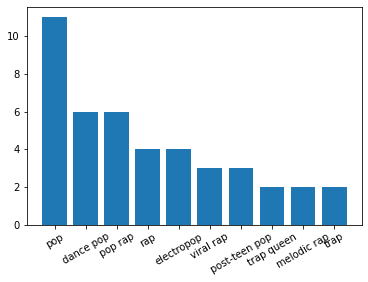

In [435]:
tok_first_plot(on_tok_songs, on_spotv50_songs, pre_spotv50_songs)

genre_dist = Counter(pre_spotv50_info.genres.dropna().values.sum()).most_common(10)
x2=[pair[1] for pair in genre_dist]
labels2=[pair[0] for pair in genre_dist]
plt.bar(height=x2, x=labels2);
plt.xticks(rotation=30);

In [436]:
pre_spotv50.sort_values("spot_v50_best_rank").head()

,,tok_first_date,tok_first_rank,spot_v50_first_date,spot_v50_first_rank,tok_best_date,tok_best_rank,spot_v50_best_date,spot_v50_best_rank
Title,Artist,,,,,,,,
yellow hearts,ant saunders,2019-10,96.0,2019-11,1.0,2019-11,7.0,2019-11-21,1.0
coronavirus,imarkkeyz,2020-03,80.0,2020-04,1.0,2020-03,80.0,2020-04-09,1.0
mia khalifa,ilovefriday,2018-08,58.0,2018-10,6.0,2018-12,39.0,2018-11-22,1.0
wap (feat. megan thee stallion),cardi b,2020-08,6.0,2020-09,2.0,2020-08,6.0,2020-09-03,2.0
stupid (feat. yung baby tate),ashnikko,2019-09,26.0,2019-10,2.0,2019-10,2.0,2019-10-17,2.0


In [437]:
# pre_spotv50_songs
ids=song_info_df.song_id.drop_duplicates()
pre_spotv50_adj = pd.DataFrame(index=ids, columns=ids)
pre_spotv50_adj = pre_spotv50_adj.fillna(0)
match = pre_spotv50_songs.song_id.values
pre_spotv50_adj.at[match, match] = 1
# pre_spotv50_adj.to_csv("pre_spotv50_adj.csv")

# Pre Spotify Top 200 (Global)

In [438]:
pre_spot200 = compare_tok_to_chart("spot_top200")
pre_spot200_info, pre_spot200_songs = analyze_chart(pre_spot200)

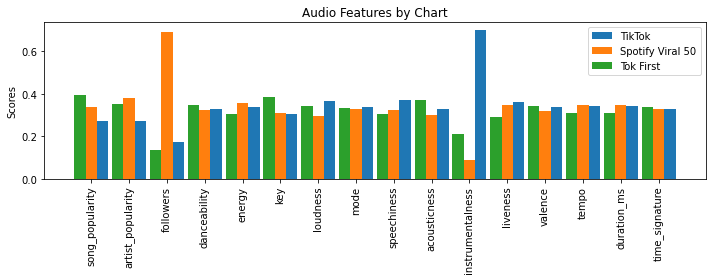

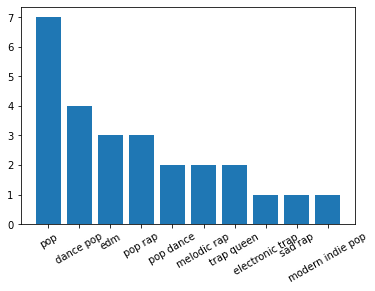

In [439]:
tok_first_plot(on_tok_songs, on_spot200_songs, pre_spot200_songs)

genre_dist = Counter(pre_spot200_info.genres.dropna().values.sum()).most_common(10)
x2=[pair[1] for pair in genre_dist]
labels2=[pair[0] for pair in genre_dist]
plt.bar(height=x2, x=labels2);
plt.xticks(rotation=30);

In [440]:
pre_spot200.sort_values("spot_top200_best_rank").head()

,,tok_first_date,tok_first_rank,spot_top200_first_date,spot_top200_first_rank,tok_best_date,tok_best_rank,spot_top200_best_date,spot_top200_best_rank
Title,Artist,,,,,,,,
blueberry faygo,lil mosey,2019-12,26.0,2020-02,53.0,2019-12,26.0,2020-04-03,8.0
party girl,staysolidrocky,2020-04,33.0,2020-05,116.0,2020-05,2.0,2020-06-12,9.0
ride it,regard,2019-04,95.0,2019-09,137.0,2019-07,22.0,2019-11-08,12.0
what if i told you that i love you,ali gatie,2019-12,73.0,2020-01,29.0,2019-12,73.0,2020-01-24,29.0
yellow hearts,ant saunders,2019-10,96.0,2019-11,49.0,2019-11,7.0,2019-11-15,45.0


In [441]:
# pre_spot200_songs
ids=song_info_df.song_id.drop_duplicates()
pre_spot200_adj = pd.DataFrame(index=ids, columns=ids)
pre_spot200_adj = pre_spot200_adj.fillna(0)
match = pre_spot200_songs.song_id.values
pre_spot200_adj.at[match, match] = 1
# for song1 in pre_spotv50_songs.song_id.values:
#     for song2 in pre_spotv50_songs.song_id.values:
#         pre_spotv50_adj.at[song1, song2] = 1
# pre_spotv50_adj.to_csv("pre_spotv50_adj.csv")

In [442]:
pre_spot200_adj.sum().sum() ==  len(match) ** 2

True

In [443]:
pre_spot200_info

,artist_popularity,followers,genres,related,songs
artist_id,,,,,
1vCWHaC5f2uS3yhpwWbIA6,86,19677257,"[dance pop, edm, pop, pop dance]","[(Afrojack, 4D75GcNG95ebPtNvoNVXhz), (Alesso, ...",{'the nights': {'song_id': '0ct6r3EGTcMLPtrXHD...
4dM6NDYSfLcspt8GLoT5aE,77,684984,"[edm, electronic trap]","[(Just A Gent, 1kwGj7uDO5WXVXtQLvGJr0), (NGHTM...",{'devil eyes': {'song_id': '7MiZjKawmXTsTNePyT...
5cj0lLjcoR7YOSnhnX0Po5,93,6518740,"[dance pop, pop, pop rap]","[(Qveen Herby, 4o4tLTIJ3eWMFerz73atcT), (Kali ...",{'rules': {'song_id': '1TMWcbxL5YF8rKsFHv5hAP'...
0bBz5bRBkExaej2HxtVfCw,73,188238,[sad rap],"[(Yxngxr1, 2jwRHcdgkRhelYEMqndDKe), (Jack Kays...",{'dancing in my room': {'song_id': '6Pgmqg15yV...
7gXb99Sf9nNmpNYeAgIQFG,74,789717,[modern indie pop],"[(DNMO, 3cMInYqk6yzf37zo8iznoz), (Ellise, 2Fov...",{'cradles': {'song_id': '1y4jsQt7MjnZhiD1L6qFB...
5zctI4wO9XSKS8XwcnqEHk,83,3595360,"[melodic rap, rap, rap conscient, trap, vapor ...","[(Flipp Dinero, 2HUwZ0kumzCSlhFcjFZfpp), (YNW ...",{'kamikaze': {'song_id': '3to5UxKsozb4T6CfwHuh...
4ofCBoyEiGSePFAG500xev,81,134772,"[dance pop, edm, pop dance, pop edm, slap hous...","[(Topic, 0u6GtibW46tFX7koQ6uNJZ), (Imanbek, 5r...",{'ride it': {'song_id': '2tnVG71enUj33Ic2nFN6k...
3PyJHH2wyfQK3WZrk9rpmP,82,996735,"[alt z, electropop, escape room, pop]","[(Qveen Herby, 4o4tLTIJ3eWMFerz73atcT), (cupca...",{'daisy': {'song_id': '0AUvWawuP0ibk4SQ3sIZjk'...
6cK3NBO6uP7hh0oyuVELFl,83,1122908,"[cali rap, dance pop, pop, pop rap, post-teen ...","[(Domo Wilson, 2h2fB0j2IN50sSwolVO1AZ), (Chell...",{'my type': {'song_id': '5KBARWIxeMGkvUax9VtVC...


# Pre Tok

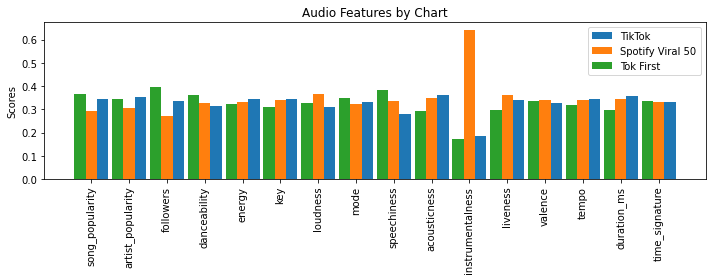

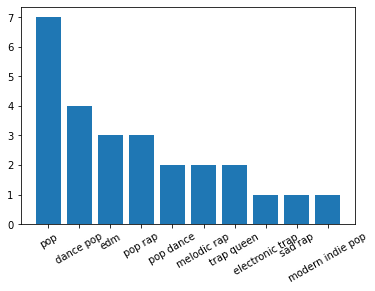

In [444]:
chart="tok"
pre_tok = library_df[library_df["spot_v50_first_date"] > library_df[f"{chart}_first_date"]][
        ['tok_first_date', "tok_first_rank", 
         f'{chart}_first_date', f"{chart}_first_rank", 
         "tok_best_date", "tok_best_rank",
         f'{chart}_best_date', f"{chart}_best_rank"]]
pre_tok_info, pre_tok_songs = analyze_chart(pre_tok)

tok_first_plot(on_spotv50_songs, on_tok_songs, pre_tok_songs)

genre_dist = Counter(pre_spot200_info.genres.dropna().values.sum()).most_common(10)
x2=[pair[1] for pair in genre_dist]
labels2=[pair[0] for pair in genre_dist]
plt.bar(height=x2, x=labels2);
plt.xticks(rotation=30);

# Pre Billboard Hot 100

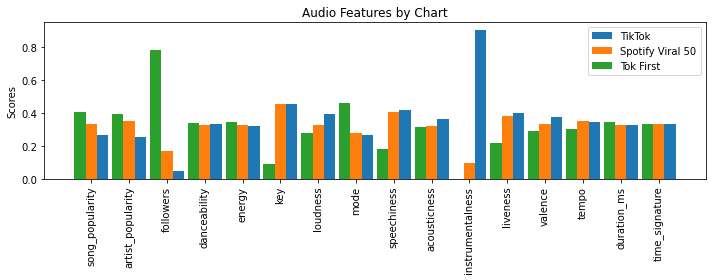

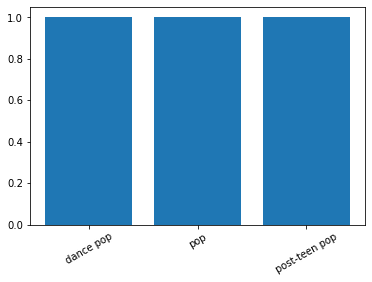

In [447]:
pre_bill100 = compare_tok_to_chart("bil_h100")
pre_bill100_info, pre_bill100_songs = analyze_chart(pre_bill200)
tok_first_plot(on_tok_songs, on_bill100_songs, pre_bill100_songs)

genre_dist = Counter(pre_bill100_info.genres.dropna().values.sum()).most_common(10)
x=[pair[1] for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels);
plt.xticks(rotation=30);

In [448]:
pre_bill100.sort_values("bil_h100_best_rank").head()

,,tok_first_date,tok_first_rank,bil_h100_first_date,bil_h100_first_rank,tok_best_date,tok_best_rank,bil_h100_best_date,bil_h100_best_rank
Title,Artist,,,,,,,,
all i want for christmas is you,mariah carey,2018-11,80.0,2018-12,29.0,2020-12,2.0,2019-12-21,1.0
7 rings,ariana grande,2019-01,13.0,2019-02,1.0,2019-02,9.0,2019-02-02,1.0
roxanne,arizona zervas,2019-10,44.0,2019-11,34.0,2019-11,6.0,2019-12-28,4.0
dance monkey,tones and i,2019-09,50.0,2019-10,96.0,2019-10,43.0,2020-02-29,4.0
blueberry faygo,lil mosey,2019-12,26.0,2020-02,62.0,2019-12,26.0,2020-07-18,8.0


# All Pres

In [594]:
all_pres = pd.concat([pre_spotv50_songs, pre_spot200_songs, pre_bill100_songs])
all_pres = all_pres.drop_duplicates("song_id")

In [595]:
#non pre songs
non_pre_ids = [song_id for song_id in song_info_df.song_id.values if song_id not in all_pres.song_id.values]
non_pres = song_info_df.loc[song_info_df.song_id.isin(non_pre_ids)]

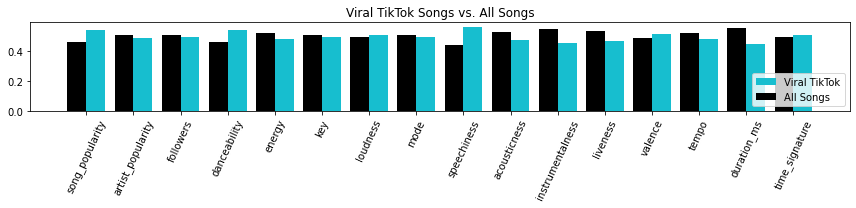

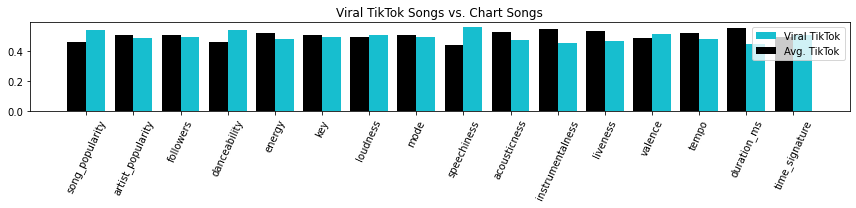

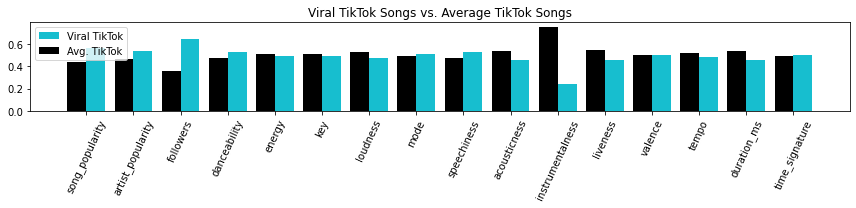

In [842]:
labels = all_pres.describe().loc["mean"].index
colors = ["black", 'tab:cyan']

################ Tok First vs All Songs ###################
pre_stats = all_pres.describe().loc["mean"].values
non_stats = non_pres.describe().loc["mean"].values

totals = [pres + non for pres, non in zip(pre_stats, non_stats)]
pre_stats /= totals
non_stats /= totals


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,3))
rects1 = ax.bar(x + width/2, pre_stats, width, label='Viral TikTok', color=colors[1])
rects2 = ax.bar(x - width/2, non_stats, width, label='All Songs', color=colors[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
ax.set_title('Viral TikTok Songs vs. All Songs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
plt.xticks(rotation=65)
fig.tight_layout()
plt.show();

#################################################

"""pre_stats = all_pres.describe().loc["mean"].values
non_stats = non_pres.describe().loc["mean"].values

x = np.arange(2)  # the label locations
width = 0.9  # the width of the bars
label = ['TikTok First', "All Songs"]

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5))


for i, (ps, ns, title) in enumerate(zip(pre_stats, non_stats, labels)):
#     print(i // 2, i % 8)
    ax[i // 4, i % 4].bar(x, height=[ps,ns], width=width, label=label, color=colors)

    # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax[i // 4, i % 4].set_ylabel('Scores')
    ax[i // 4, i % 4].set_title(title)

fig.tight_layout()
# plt.legend()
plt.show();"""

################## Viral TikTok vs. Chart Songs ################

pre_stats = all_pres.describe().loc["mean"].values
to_drop = [song_id for song_id in on_tok_songs.song_id if song_id not in non_pres.song_id]
non_stats = non_pres.drop(non_pres.loc[non_pres.song_id.isin(to_drop)].index)
non_stats = non_pres.describe().loc["mean"].values

totals = [pres + non for pres, non in zip(pre_stats, non_stats)]
pre_stats /= totals
non_stats /= totals


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,3))
rects1 = ax.bar(x + width/2, pre_stats, width, label='Viral TikTok', color=colors[1])
rects2 = ax.bar(x - width/2, non_stats, width, label='Avg. TikTok', color=colors[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
ax.set_title('Viral TikTok Songs vs. Chart Songs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=65)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show();

####################Tok First vs Tok ##################

pre_stats = all_pres.describe().loc["mean"].values
non_stats = on_tok_songs.describe().loc["mean"].values

totals = [pres + non for pres, non in zip(pre_stats, non_stats)]
pre_stats /= totals
non_stats /= totals


x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(12,3))
rects1 = ax.bar(x + width/2, pre_stats, width, label='Viral TikTok', color=colors[1])
rects2 = ax.bar(x - width/2, non_stats, width, label='Avg. TikTok', color=colors[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
ax.set_title('Viral TikTok Songs vs. Average TikTok Songs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=65)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show();

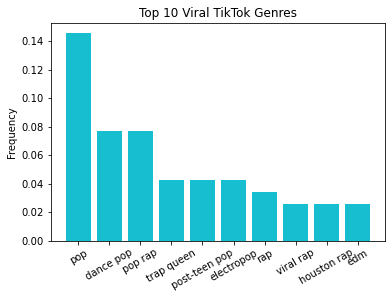

In [831]:
genre_dist = Counter(all_pres.genres.dropna().values.sum()).most_common(10)
totals = sum(Counter(all_pres.genres.dropna().values.sum()).values())
x=[pair[1] / totals for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels, color=colors[1]);
plt.xticks(rotation=30);
plt.title("Top 10 Viral TikTok Genres");
plt.ylabel("Frequency");

Text(0, 0.5, 'Frequency')

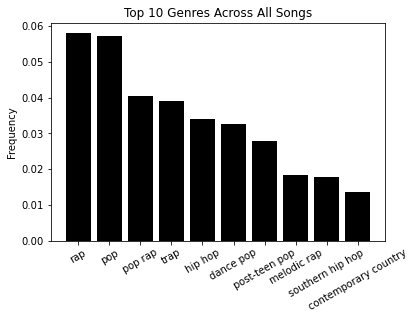

In [830]:
genre_dist = Counter(non_pres.genres.dropna().values.sum()).most_common(10)
totals = sum(Counter(non_pres.genres.dropna().values.sum()).values())
x=[pair[1] / totals for pair in genre_dist]
labels=[pair[0] for pair in genre_dist]
plt.bar(height=x, x=labels, color=colors[0]);
plt.xticks(rotation=30);
plt.title("Top 10 Genres Across All Songs");
plt.ylabel("Frequency");

# Adjaceny Matrices

In [597]:
# song_x_song, all pre chart adjacencies
ids=song_info_df.song_id.drop_duplicates()
all_pres_adj = pd.DataFrame(index=ids, columns=ids)
all_pres_adj = all_pres_adj.fillna(0)
match = all_pres.song_id.values
all_pres_adj.at[match, match] = 1
all_pres_adj.sum().sum() ==  len(match) ** 2

In [737]:
# pre chart adjacencies by song
genres = all_pres.genres.sum()
ids = all_pres.song_id.drop_duplicates()
song_x_genre = pd.DataFrame(index=ids, columns=genres)
song_x_genre = song_x_genre.fillna(0)
for song_id in song_x_genre.index:
    for g in all_pres.loc[all_pres.song_id == song_id].genres[0]:
        song_x_genre.at[song_id,g] = 1
# song_x_genre.to_csv("song_x_genre.csv")

In [760]:
# pd.DataFrame(index=all_pres.index.get_level_values("Title"))
all_pres['song_id'].reset_index().merge(song_x_genre, on="song_id").to_csv("song_x_genre.csv")

In [602]:
all_pres_adj.to_csv("all_pres_adj.csv")

In [770]:
# song_x_chart adjacencies
song_x_chart = pd.DataFrame(index=library_df.index)
ids = song_info_df['song_id']
song_x_chart.at[ids.keys(), "song_id"] = ids.values
charts = ["spot_v50", "spot_top200", "bil_h100"]
for chart in charts:
    tok_first = compare_tok_to_chart(chart)
    song_x_chart[chart] = [int(not x) for x in library_df[f'{chart}_first_date'].isnull()]
    song_x_chart[f"pre_{chart}"] = 0
    song_x_chart.at[tok_first.index, f"pre_{chart}"] = 1
    print(chart)
    print(tok_first[["tok_first_rank", "tok_best_rank", f"{chart}_first_rank", f"{chart}_best_rank"]].describe().loc["mean"], "\n")
    
# song_x_chart.to_csv("song_x_chart.csv")

spot_v50
tok_first_rank         40.216216
tok_best_rank          23.702703
spot_v50_first_rank    19.378378
spot_v50_best_rank     18.405405
Name: mean, dtype: float64 

spot_top200
tok_first_rank             49.571429
tok_best_rank              26.285714
spot_top200_first_rank    132.285714
spot_top200_best_rank      98.214286
Name: mean, dtype: float64 

bil_h100
tok_first_rank         44.1250
tok_best_rank          16.1875
bil_h100_first_rank    69.2500
bil_h100_best_rank     43.8125
Name: mean, dtype: float64 



In [771]:
song_x_chart.reset_index().drop(columns=["song_id", "Artist"])#.to_csv("song_x_chart.csv")

,Title,spot_v50,pre_spot_v50,spot_top200,pre_spot_top200,bil_h100,pre_bil_h100
0,ten,0,0,0,0,0,0
1,#filterswitch,0,0,0,0,0,0
2,mis manos,0,0,0,0,0,0
3,dumb blonde (feat. nicki minaj),0,0,1,0,0,0
4,wap（feat. megan thee stallion）,0,0,0,0,0,0
...,...,...,...,...,...,...,...
10472,hindi tayo pwede,1,0,0,0,0,0
10473,prop me up beside the jukebox (if i die),1,0,0,0,0,0
10474,"rewind, replay, rebound",0,0,0,0,0,0
10475,shock da world,0,0,0,0,1,0
